In [178]:
import os
import time
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as data
from torchsummary import summary

## Proprecessing

In [179]:
NCLASSES = 43
BATCH_SIZE = 64
CLASSES = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)', 
    2: 'Speed limit (50km/h)', 
    3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 
    5: 'Speed limit (80km/h)', 
    6: 'End of speed limit (80km/h)', 
    7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing veh over 3.5 tons', 
    11: 'Right-of-way at intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No vehicles', 
    16: 'Veh > 3.5 tons prohibited', 
    17: 'No entry', 
    18: 'General caution', 
    19: 'Dangerous curve left', 
    20: 'Dangerous curve right', 
    21: 'Double curve', 
    22: 'Bumpy road', 
    23: 'Slippery road', 
    24: 'Road narrows on the right', 
    25: 'Road work', 
    26: 'Traffic signals', 
    27: 'Pedestrians', 
    28: 'Children crossing', 
    29: 'Bicycles crossing', 
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing', 
    32: 'End speed + passing limits', 
    33: 'Turn right ahead', 
    34: 'Turn left ahead', 
    35: 'Ahead only', 
    36: 'Go straight or right', 
    37: 'Go straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Roundabout mandatory', 
    41: 'End of no passing', 
    42: 'End no passing veh > 3.5 tons'
}

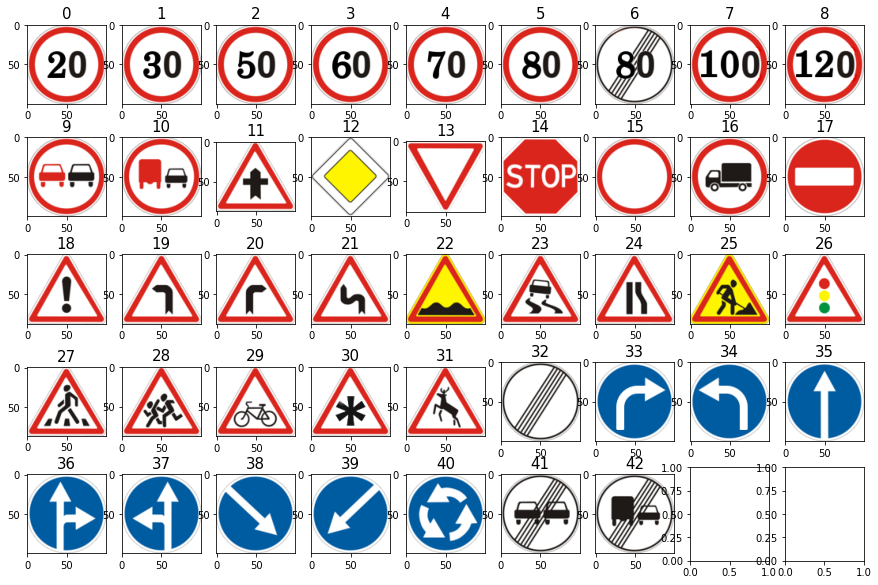

In [181]:
fig, axs = plt.subplots(5, 9, figsize=(15, 10))
for i in range(NCLASSES):
    row = i // 9
    col = i % 9
    image_name = "data/Meta/{}.png".format(i)
    img = Image.open(image_name)
    axs[row, col].imshow(img)
    axs[row, col].set_title(str(i), fontsize=15)
    
# plt.savefig("classes.png", bbox_inches="tight", pad_inches=0.5)

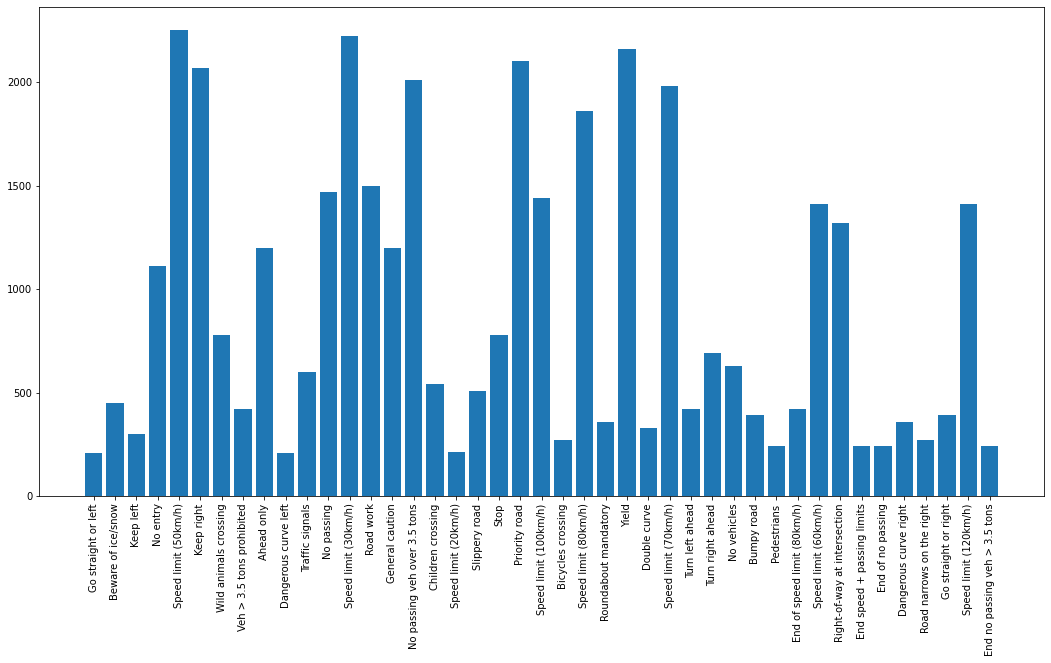

In [184]:
folders = os.listdir("data/train")
D = {}

for folder in folders:
    train_files = os.listdir("data/train/{}".format(folder))
    D[CLASSES[int(folder)]] = len(train_files)

plt.figure(figsize=(18, 9))
plt.bar(D.keys(), D.values())
plt.xticks(list(D.keys()), rotation='vertical')
plt.show()

In [185]:
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])

train_data_path = "data/Train"
train_data = datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 31373
Number of validation samples = 7844


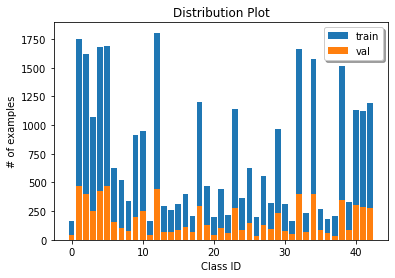

In [188]:
# Plot histogram for training and validation data

train_hist = [0] * NCLASSES
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0] * NCLASSES
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(NCLASSES), train_hist, label="train")
plt.bar(range(NCLASSES), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [189]:
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

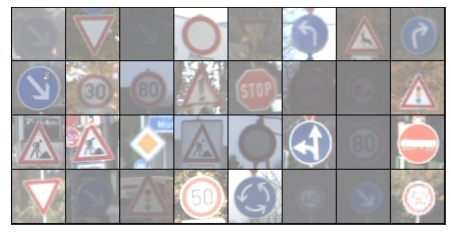

In [190]:
from torchvision.utils import make_grid, save_image

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
show_batch(train_loader)

## Build model from scrach

In [191]:
class Net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

# Resnet50

In [51]:
from torchvision.models.resnet import resnet50
model=resnet50(pretrained=False)
model.fc=nn.Linear(2048, NCLASSES)

In [192]:
learning_rate= 0.001
model = Net(NCLASSES)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [193]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [195]:
print(summary(model, (3, 112, 112)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

In [196]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [197]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for (images, labels) in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        acc = calculate_accuracy(output, labels)
        opt.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [198]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run predictions
            output = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [202]:
EPOCHS = 2
train_loss_list = [0] * EPOCHS
train_acc_list = [0] * EPOCHS
val_loss_list = [0] * EPOCHS
val_acc_list = [0] * EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))
    train_loss_list[epoch], train_acc_list[epoch] = train(model, train_loader, optimizer, criterion)
    val_loss_list[epoch], val_acc_list[epoch] = evaluate(model, val_loader, optimizer, criterion)
    
    print("Training: Loss = %.4f, Accuracy = %.4f" % (train_loss_list[epoch], train_acc_list[epoch]))
    print("Validation: Loss = %.4f, Accuracy = %.4f" % (val_loss_list[epoch], val_acc_list[epoch]))

  0%|          | 1/491 [00:00<01:09,  7.06it/s]

Epoch-0: 


  0%|          | 1/491 [00:00<01:07,  7.26it/s]

Training: Loss = 0.7631, Accuracy = 0.7480
Validation: Loss = 0.2360, Accuracy = 0.9210
Epoch-1: 


100%|██████████| 123/123 [00:07<00:00, 15.70it/s]

Training: Loss = 0.2852, Accuracy = 0.9081
Validation: Loss = 0.1034, Accuracy = 0.9698


In [203]:
def read_image(path):
    img = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize([112, 112]),
        transforms.ToTensor(),
    ])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor

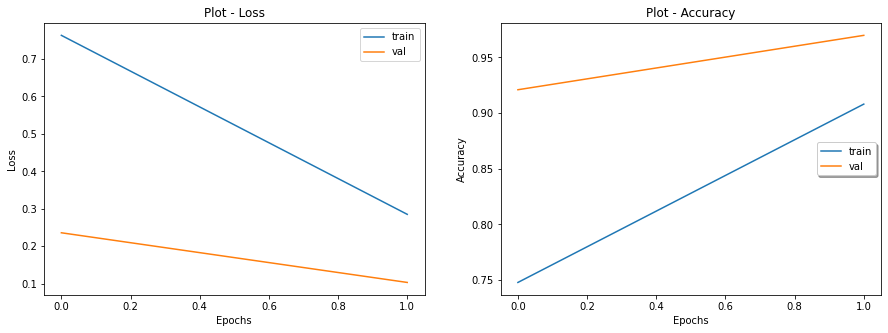

In [204]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [37]:
MODEL_FOLDER = "."
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
# PATH_TO_MODEL = MODEL_FOLDER + "/model.pth"
PATH_TO_MODEL = MODEL_FOLDER + "/model_resbet50.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at ./model_resbet50.pth


In [209]:
model = Net(43)
model.load_state_dict(torch.load("model.pth", map_location='cpu'))
model = model.cuda()
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inpla

In [210]:
img_path = "data/Train/12/00012_00000_00001.png"

def predict(image_path):
    img = read_image(img_path)
    img = img.to(device)
    output = model(img)

    prob = F.softmax(output, dim=1)
    top_p, top_class = prob.topk(5, dim=1)

    return top_p.cpu().detach().numpy()[0].tolist(), top_class.cpu().detach().numpy()[0].tolist()

print(predict(img_path))

([1.0, 1.6292062100450866e-14, 1.442821522792872e-14, 7.527983295865966e-15, 6.575394479153374e-16], [4, 37, 28, 5, 10])


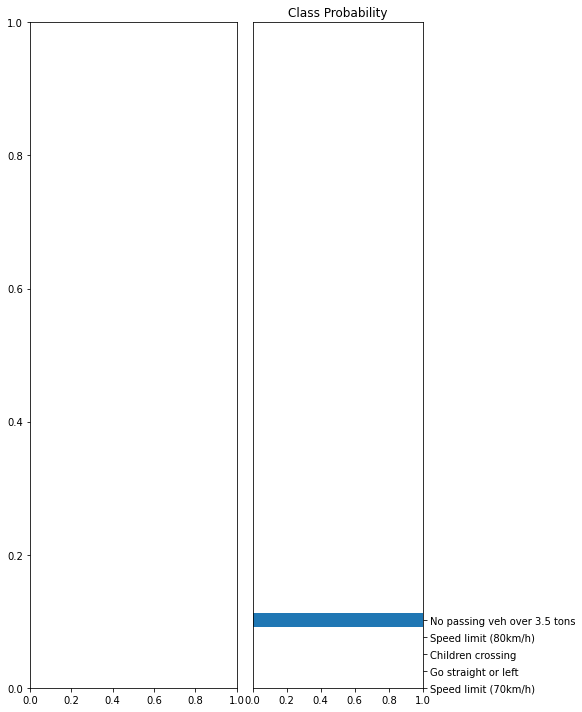

In [212]:
def show_image_and_prediction(image_path):
    
    top_p, top_c = predict(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(8,10), ncols=2)
#     ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
    
    ax2.set_aspect(0.1)
    ax2.barh(top_c, top_p)
    ax2.set_yticks(np.arange(len(top_c)))
    ax2.set_yticklabels([CLASSES[i] for i in top_c])
    ax2.set_title('Class Probability')
    ax2.yaxis.tick_right()
    ax2.set_xlim(0, 1)
    plt.tight_layout()

show_image_and_prediction(img_path)